# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
# For my commoditity, I am going to import all the packages that I will be needing in this cell.
import os
import cv2 
import torch

import numpy as np
from glob import glob
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from PIL import ImageFile
import torch.tensor as tensor
import torch.optim as optim
import matplotlib.pyplot as plt                        
%matplotlib inline
import torch.nn.functional as F
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

ImageFile.LOAD_TRUNCATED_IMAGES = True


# check if CUDA is available
use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

aux_files = np.array(glob("/data/dog_images/*/*"))
classes = [os.path.basename(x) for x in aux_files]
classes = set(classes) #Only unique values
classes = list(classes)
#print(classes)


# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))
print('There are %d total classes of dog\'s breed images.' % len(classes))

There are 13233 total human images.
There are 8351 total dog images.
There are 133 total classes of dog's breed images.


In [3]:
def get_dog_breed_class(label, classes):
    for breed in classes:
        aux = int(breed.split('.')[0])
        if (aux == label):
            return breed.split('.')[1]
            
    

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


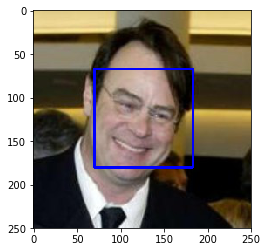

In [4]:
                              

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 


******** Number of human faces detected in human's images = 98% ********


******** Number of human faces detected in dog's images =   17% ********

In [6]:


human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
n_faces_detected = 0
for human in tqdm(human_files_short):
    n_faces_detected += face_detector(human)

n_dogs_detected = 0
for dog in tqdm(dog_files_short):
    n_dogs_detected += face_detector(dog)

print('******** Number of human faces detected in human\'s images = ' + str(n_faces_detected) + '% ********')
print('******** Number of human faces detected in dog\'s images =   ' + str(n_dogs_detected)  + '% ********')


100%|██████████| 100/100 [00:30<00:00,  3.33it/s]

******** Number of human faces detected in human's images = 98% ********
******** Number of human faces detected in dog's images =   17% ********


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [7]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.
#print(dog_files_short)

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [8]:


# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

# Freeze training for all "features" layers
for param in VGG16.features.parameters():
    param.requires_grad = False

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

In [9]:




#data_dir_humans = '/data/lfw/'
#data_dir_dog = '/data/dog_images/'

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    trans_to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    trans_resize = transforms.RandomResizedCrop(224)
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
     # Data loading code
    img = Image.open(img_path)
    ## Return the *index* of the predicted class for that image

    img = trans_resize(img)
    img_tensor = trans_to_tensor(img)
    #img_norm_tensor = normalize(img_tensor)
    #print(img_norm_tensor.shape)
    img_tensor = img_tensor.unsqueeze_(0)
    if use_cuda:
        img_tensor = img_tensor.cuda()
    #print(img_norm_tensor.shape)
    prediction = VGG16(img_tensor)
    values, indices = torch.max(prediction,1)
    return indices[0] # predicted class index

#prediction = VGG16_predict('/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg')
#print(prediction.item())

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        True if the index is between 151 and 268(inclusive) which means it has predicted any breed of any dog.
    '''
    trans_to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    trans_resize = transforms.RandomResizedCrop(224)
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
     # Data loading code
    img = Image.open(img_path)
    img = trans_resize(img)
    img_tensor = trans_to_tensor(img)
    img_tensor = img_tensor.unsqueeze_(0)
    if use_cuda:
        img_tensor = img_tensor.cuda()
    prediction = VGG16(img_tensor)
    values, indices = torch.max(prediction,1)
    prediction = indices.item()
    if_dog = False
    if ((prediction >= 151) and (prediction <= 268)):
        if_dog = True
    return if_dog # true/false



### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


******** Number of human detected as dogs in human's images = 0% ********


******** Number of dogs detected in dog's images =   82% ********


In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
n_humans_detected_as_dog = 0

for human in tqdm(human_files_short):
    n_humans_detected_as_dog += dog_detector(human)
    
n_dogs_detected_as_dog = 0
for dog in tqdm(dog_files_short):
    n_dogs_detected_as_dog += dog_detector(dog)

print('******** Number of human detected as dog in human\'s images = ' + str(n_humans_detected_as_dog) + '% ********')
print('******** Number of dogs detected in dog\'s images =   ' + str(n_dogs_detected_as_dog)  + '% ********')


100%|██████████| 100/100 [00:04<00:00, 26.97it/s]

******** Number of human detected as dog in human's images = 0% ********
******** Number of dogs detected in dog's images =   79% ********


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

### Obtain Pre-trained RESNET-50 Model

In [12]:
# define RESNET model
RESNET50 = models.resnet50(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    RESNET50 = RESNET50.cuda()

#print(RESNET50)
    
# Freeze training for all layers
for param in RESNET50.parameters():
    param.requires_grad = False


## Define RESNET50 prediction function 

In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def RESNET50_dog_detector(img_path):
    ## TODO: Complete the function.
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        True if the index is between 151 and 268(inclusive) which means it has predicted any breed of any dog.
    '''
    trans_to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    trans_resize = transforms.RandomResizedCrop(224)
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
     # Data loading code
    img = Image.open(img_path)
    img = trans_resize(img)
    img_tensor = trans_to_tensor(img)
    img_tensor = img_tensor.unsqueeze_(0)
    if use_cuda:
        img_tensor = img_tensor.cuda()
    prediction = RESNET50(img_tensor)
    values, indices = torch.max(prediction,1)
    #print("Max index " + str(indices.item()))
    prediction = indices.item()
    if_dog = False
    if ((prediction >= 151) and (prediction <= 268)):
        if_dog = True
    return if_dog # true/false

In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
n_humans_detected_as_dog = 0

for human in tqdm(human_files_short):
    n_humans_detected_as_dog += RESNET50_dog_detector(human)
    
n_dogs_detected_as_dog = 0
for dog in tqdm(dog_files_short):
    n_dogs_detected_as_dog += RESNET50_dog_detector(dog)

print('******** Number of human detected as dog in human\'s images = ' + str(n_humans_detected_as_dog) + '% ********')
print('******** Number of dogs detected in dog\'s images =   ' + str(n_dogs_detected_as_dog)  + '% ********')



100%|██████████| 100/100 [00:03<00:00, 29.12it/s]

******** Number of human detected as dog in human's images = 0% ********
******** Number of dogs detected in dog's images =   0% ********


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [15]:
# define training and test data directories
data_dir = '/data/dog_images/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')


In [16]:
# load and transform data using ImageFolder

data_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(10),
                                     transforms.CenterCrop(224), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                          std=(0.229, 0.224, 0.225))])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num valid images: ', len(valid_data))
print('Num test images: ', len(test_data))

# define dataloader parameters
batch_size = 128
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=False)


Num training images:  6680
Num valid images:  835
Num test images:  836


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

 - All the images have been resized to the same size = 224 x 224 x 3.
- I chose this size because as tested before in the transfer learning with VGG16 and RESNET50 take their input as 224.


- Yes, I decided to augment the data because the dog's pictures are normally never in the same position, there is no standard "behaviour" in the pictures. All pictures are different as in color, positions, etc. This way the neural network will be more robust to these types of changes. I used horizontal flip, size crop.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [17]:


# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # Input == 224x224x3
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) #output = 224x224x16/2 = 112x112x16
        # Next layer: with maxpool
        self.pool = nn.MaxPool2d(2, 2)
        # Next layer's depth will be 16
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  #output = 112x112x32/2 = 56x56x32
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  #output = 56x56x64/2 = 28x28x64
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1) #output = 28x28x128/2 = 14x14x128
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1) #output = 14x14x256/2 = 7x7x256
        
        
        #Fully connected layer:
        self.fc1 = nn.Linear(7*7*256, 9408)
        self.fc2 = nn.Linear(9408, 6272)
        self.fc3 = nn.Linear(6272, 3136)
        self.fc4 = nn.Linear(3136, len(classes))
        
        #Dropout layer
        self.dropout = nn.Dropout(p=0.25)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        #Conv 2
        x = self.pool(F.relu(self.conv2(x)))
        #Conv 3
        x = self.pool(F.relu(self.conv3(x)))
        #Conv 4
        x = self.pool(F.relu(self.conv4(x)))
        #Conv 5
        x = self.pool(F.relu(self.conv5(x)))
        # Flatten:
        x = x.view(-1, 7*7*256)
        # Fully connected layers:
        x = F.relu(self.fc1(x))
        
        # add dropout layer
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = self.fc4(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=12544, out_features=9408, bias=True)
  (fc2): Linear(in_features=9408, out_features=6272, bias=True)
  (fc3): Linear(in_features=6272, out_features=3136, bias=True)
  (fc4): Linear(in_features=3136, out_features=133, bias=True)
  (dropout): Dropout(p=0.25)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

- First of all I wanted to try with 5 Convulational layer and with 5 max pool in each convolutional layer in between.
       The reasoning for taking the inputs are:


   <font color=blue>Input = 224x224x3</font> $\Longrightarrow$ __Conv Layer 1__ --> Max pool (2x2) $\Longrightarrow$ <font color=green> output = 224x224x16/2 = 112x112x16 </font>


   <font color=blue>Input = 112x112x16</font> $\Longrightarrow$ __Conv Layer 2__ --> Max pool (2x2) $\Longrightarrow$  <font color=green> output = 112x112x32/2 = 56x56x32</font>


   <font color=blue>Input = 56x56x32</font> $\Longrightarrow$ __Conv Layer 3__ --> Max pool (2x2) $\Longrightarrow$ <font color=green> output = 56x56x64/2 = 28x28x64</font>


   <font color=blue>Input = 28x28x64</font> $\Longrightarrow$ __Conv Layer 4__ --> Max pool (2x2) $\Longrightarrow$ <font color=green> output = 28x28x128/2 = 14x14x128</font>


   <font color=blue>Input = 14x14x128</font> $\Longrightarrow$ __Conv Layer 5__ --> Max pool (2x2) $\Longrightarrow$ <font color=green> output = 14x14x256/2 = 7x7x256</font>

- Final output of the convolutional networks $\Longrightarrow$ _7x7x256_



- After the convolutional layers, I added the deep neural networks for the classification purposes. I added 5 layers.

      First input will _7x7x256_ to the deep neural network.



- I calculated the classes list with the filepaths of the images but only taking the name of the breeds '/data/dog_images/train/_103.Mastiff_' I created a set to get unique values. So the length of the classes list will be the length of the final output of our deep neural network:

        self.fc4 = nn.Linear(3136, len(classes))




- Dropout with p=0.25 is also added after each fully connected layer in order to avoid overfitting of data.
   


- Activation function: The chosen activation function = ReLu. For the last fully connect layer, no activation layer has been chosen because I will be using a CrossEntropyLoss in the following step and in pytorch the softmax function is already included in the loss function.

- Number of epochs --> I reduced the number of epochs from 100 (default) to 30 because when it was training for 100, I saw that after 19 or 20, the validation loss starts to fluctuate and it increases. This can cause overfitting and we want to avoid it. So, I think that training the model with 25-30 epochs would be more than enough.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [18]:


### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer. We will start with a very low learning rate.
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.0001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [19]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                #print('Training on GPU')
                data, target = data.cuda(), target.cuda()
                
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
        
            ## find the loss and update the model parameters accordingly
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            ## record the average training loss, using something like
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # update training loss
            #train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            with torch.no_grad():
                output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


# train the model
loaders_scratch = {'train': train_loader,
                   'valid': valid_loader,
                   'test': test_loader
                  }


In [21]:
n_epochs = 30
model_scratch = train(n_epochs, loaders_scratch, model_scratch, optimizer_scratch, ##
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 0.000376 	Validation Loss: 0.004911
Validation loss decreased (inf --> 0.004911).  Saving model ...
Epoch: 2 	Training Loss: 0.000361 	Validation Loss: 0.004921
Epoch: 3 	Training Loss: 0.000349 	Validation Loss: 0.005082
Epoch: 4 	Training Loss: 0.000333 	Validation Loss: 0.005153
Epoch: 5 	Training Loss: 0.000318 	Validation Loss: 0.005154
Epoch: 6 	Training Loss: 0.000309 	Validation Loss: 0.005304
Epoch: 7 	Training Loss: 0.000295 	Validation Loss: 0.005449
Epoch: 8 	Training Loss: 0.000292 	Validation Loss: 0.005280
Epoch: 9 	Training Loss: 0.000270 	Validation Loss: 0.005865
Epoch: 10 	Training Loss: 0.000257 	Validation Loss: 0.005717
Epoch: 11 	Training Loss: 0.000229 	Validation Loss: 0.006120
Epoch: 12 	Training Loss: 0.000221 	Validation Loss: 0.006292
Epoch: 13 	Training Loss: 0.000209 	Validation Loss: 0.006373
Epoch: 14 	Training Loss: 0.000194 	Validation Loss: 0.006655
Epoch: 15 	Training Loss: 0.000184 	Validation Loss: 0.006838
Epoch: 16 	Trai

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [22]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [23]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.987808


Test Accuracy: 15% (126/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [24]:
## TODO: Specify data loaders
# prepare data loaders
batch_size = 64
num_workers = 0
data_train_transforms = transforms.Compose([transforms.Resize(size=258),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

valid_test_transforms = transforms.Compose([transforms.Resize(size=258),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

train_transfer_data = datasets.ImageFolder(train_dir, transform=data_train_transforms)
valid_transfer_data = datasets.ImageFolder(valid_dir, transform=valid_test_transforms)
test_transfer_data = datasets.ImageFolder(test_dir, transform=valid_test_transforms)

# print out some data stats
print('Num training images: ', len(train_transfer_data))
print('Num valid images: ', len(valid_transfer_data))
print('Num test images: ', len(test_transfer_data))
train_transfer_loader = torch.utils.data.DataLoader(train_transfer_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_transfer_loader = torch.utils.data.DataLoader(valid_transfer_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_transfer_loader = torch.utils.data.DataLoader(test_transfer_data, batch_size=16, 
                                          num_workers=num_workers, shuffle=False)

loaders_transfer = { 'train': train_transfer_loader,
                     'valid': valid_transfer_loader,
                     'test' : test_transfer_loader
                    }


Num training images:  6680
Num valid images:  835
Num test images:  836


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [25]:
## TODO: Specify model architecture
# I am going to use vgg16
model_transfer = models.vgg16(pretrained = True)



#print(model_transfer)
# After printing the model's parameters, I can see that the input is of depth 3 and investigating, it takes images of 224x224


for param in model_transfer.parameters():
    param.requires_grad = False


n_inputs = model_transfer.classifier[6].in_features

model_transfer.classifier[6] = nn.Sequential(nn.Linear(n_inputs, 1024),
                                             nn.ReLU(),
                                             nn.Dropout(0.5),
                                             nn.Linear(1024, 512),
                                             nn.ReLU(),
                                             nn.Dropout(0.5),
                                             nn.Linear(512, len(classes))
                                            
                                            )

for param in model_transfer.classifier[6].parameters():
    param.requires_grad = True

    
#print(model_transfer.classifier)
print(model_transfer)
if use_cuda:
    model_transfer = model_transfer.cuda()
    print("Training in GPU")


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

- First of all, I instanciate model_transfer using vgg16() from pytorch models' library. VGG16 has been already trained with dog images so I am choosing this pre-trained model.

- When I experimented with vgg16 before in previous steps, the result was already good so I am expecting better results with vgg16 after personalizing the classifier layer.

- I added 3 more fully connected layers in the last classifier layer in the pretrained model. I did this because I had tried by only changing the number of outputs of the classifier[6] to 133 (classes of dogs' breeds) but I did not get good results. So I added more layers.

- Also we freeze all the features parameters and the classifier layers except the classifier layer 6 because we don't want them to change and also to improve the training time.

- After that I add Cross Entropy Loss as it is a classifying problem.

- And in the optimizer I specify that I would like to optimize only the classifier 6th layer.

- I trained the network with only 7 epochs because as you can see in the results after epoch 4, the training starts overfitting and we do not want that.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [26]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier[6].parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [27]:
#import workspace_utils
from workspace_utils import active_session
# train the model
n_epochs = 7

 
with active_session():
    #with torch.autograd.profiler.profile(use_cuda=True) as prof:
    model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')
    #print(prof)
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.000385 	Validation Loss: 0.001056
Validation loss decreased (inf --> 0.001056).  Saving model ...
Epoch: 2 	Training Loss: 0.000171 	Validation Loss: 0.000714
Validation loss decreased (0.001056 --> 0.000714).  Saving model ...
Epoch: 3 	Training Loss: 0.000139 	Validation Loss: 0.000596
Validation loss decreased (0.000714 --> 0.000596).  Saving model ...
Epoch: 4 	Training Loss: 0.000129 	Validation Loss: 0.000641
Epoch: 5 	Training Loss: 0.000117 	Validation Loss: 0.000559
Validation loss decreased (0.000596 --> 0.000559).  Saving model ...
Epoch: 6 	Training Loss: 0.000110 	Validation Loss: 0.000638
Epoch: 7 	Training Loss: 0.000110 	Validation Loss: 0.000533
Validation loss decreased (0.000559 --> 0.000533).  Saving model ...


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [28]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.557374


Test Accuracy: 82% (688/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [29]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_transfer_data.classes]
#print(train_transfer_data.classes)
#print(class_names)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))


def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    trans_to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    trans_resize = transforms.RandomResizedCrop(224)
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
     # Data loading code
    img = Image.open(img_path)
    img = trans_resize(img)
    img_tensor = trans_to_tensor(img)
    img_tensor = img_tensor.unsqueeze_(0)
    if use_cuda:
        img_tensor = img_tensor.cuda()
    
    # Turn on evaluation mode
    model_transfer.eval()
    
    # Get predicted category for image
    with torch.no_grad():
        output = model_transfer(img_tensor)
        prediction = torch.argmax(output).item()
        
    # Turn off evaluation mode
    model_transfer.train()
    # Use prediction to get dog breed
    breed = get_dog_breed_class(prediction, classes)
    return breed

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [30]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if (face_detector(img_path)):
        #human face detected
        print('\nHuman face detected!\n\n')
        plt.imshow(Image.open(img_path))
        plt.show()
        print('\nYou look like ' + predict_breed_transfer(img_path) + '\n\n')
        print('\n********************************************************************\n\n')
    elif (dog_detector(img_path)):
        #Dog detected
        print('\nDog detected!')
        plt.imshow(Image.open(img_path))
        plt.show()
        print('\nThis is a picture of: ' + predict_breed_transfer(img_path) + '\n\n')
        print('\n********************************************************************\n\n')
    else:
        print('\nSorry! Nor human nor dog detected! ')
        plt.imshow(Image.open(img_path))
        plt.show()
        print('\n********************************************************************\n\n')
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.



__Answer:__ (Three possible points for improvement)

- The output is good because when I ran the app in my personal images, cats (at least one of them) and foods were not detected as human nor dogs. However, when there is a human + dog in the same image then the outout is not as expected.


- __Improvements:__
    - By reasearching I found this comparison: https://www.learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/ and trying with other models like Inception would be a good idea, it is available on pytorch as pretrained model and also as in GPU wise it is not that bad.
    
    - May be by adding more layers in the classifier, we could obtain better results.
    
    - Probably, adding more variety of pictures from different dogs breed in different situation could also help a lot. Also, augmenting the pictures might help a lot better. May be introducing dogs' pictures as puppies might also be interesting.
    

Disclaimer of images: 
- Some images were taken by me and some were taken from https://www.pexels.com/ free of use.

Starting App......

Human face detected!




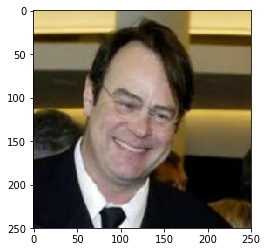


You look like Chesapeake_bay_retriever



********************************************************************



Human face detected!




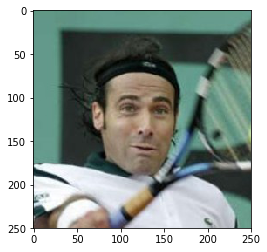


You look like Curly-coated_retriever



********************************************************************



Human face detected!




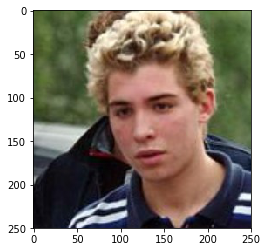


You look like Bernese_mountain_dog



********************************************************************



Dog detected!


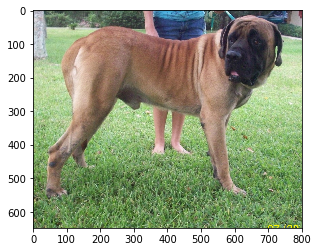


This is a picture of: Brussels_griffon



********************************************************************



Sorry! Nor human nor dog detected! 


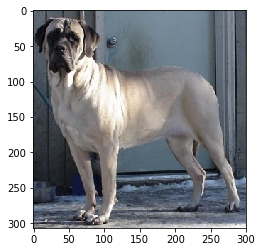


********************************************************************



Sorry! Nor human nor dog detected! 


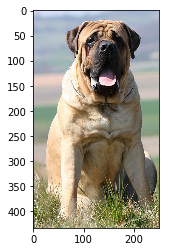


********************************************************************




In [31]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
print("Starting App......")
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

######################
##Starting App......##
######################




Sorry! Nor human nor dog detected! 


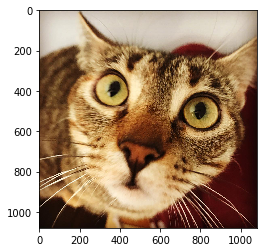


********************************************************************



Sorry! Nor human nor dog detected! 


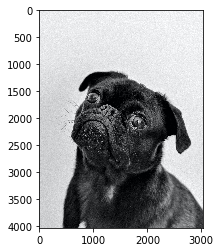


********************************************************************



Human face detected!




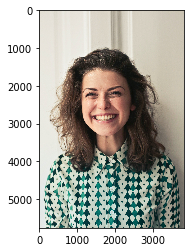


You look like English_springer_spaniel



********************************************************************



Sorry! Nor human nor dog detected! 


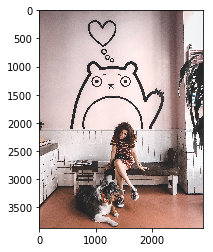


********************************************************************



Dog detected!


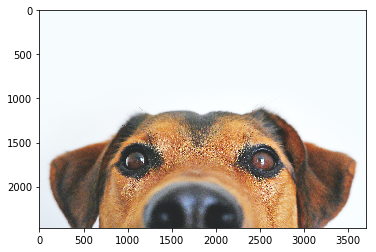


This is a picture of: Irish_wolfhound



********************************************************************



Human face detected!




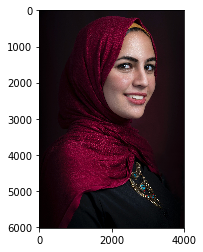


You look like Xoloitzcuintli



********************************************************************



Sorry! Nor human nor dog detected! 


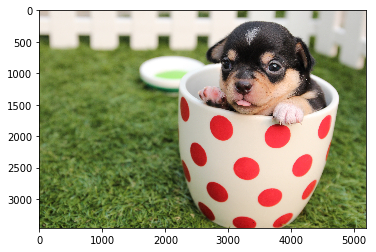


********************************************************************



Sorry! Nor human nor dog detected! 


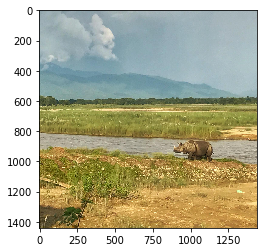


********************************************************************



Human face detected!




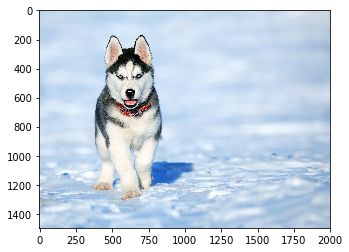


You look like Anatolian_shepherd_dog



********************************************************************



Dog detected!


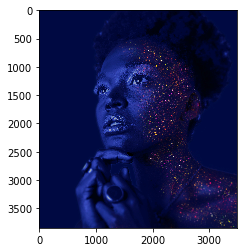


This is a picture of: French_bulldog



********************************************************************



Dog detected!


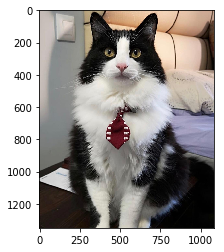


This is a picture of: Alaskan_malamute



********************************************************************



Sorry! Nor human nor dog detected! 


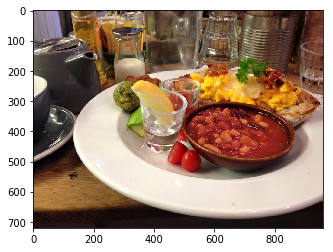


********************************************************************



Dog detected!


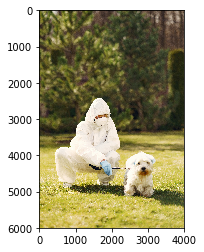


This is a picture of: Greater_swiss_mountain_dog



********************************************************************



Dog detected!


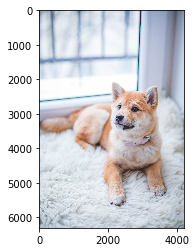


This is a picture of: Field_spaniel



********************************************************************



Dog detected!


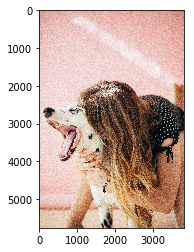


This is a picture of: Chihuahua



********************************************************************




In [32]:


img_files = np.array(glob("my_images/*"))
print("######################")
print("##Starting App......##")
print("######################\n\n\n")
for img_path in img_files:
    run_app(img_path)